# Likelihood Calculation and Optimization

**The flow of the analysis:**
<br />
<br />
We run *loglikelihood_trueW* once to with the setting that generates bootstrap uncertainties generated by uncertainties in $f_0(w)$. We store the 3-tuple ($z$-space mid bins, $\\nu(z)$ in counts, uncertainty in $\\nu(z)$ due to uncertainty in $f_0(w)$, in a data named *w_file*.

<center>$\downarrow$</center>

We load the midplane velocity profile ( $f_0(w)$ ) using *fetchWData* and generates its histogram in $w$-space. Then we generate a smooth interpolated function for $f_0(w)$ using *fetchWDist_gaia*. Together with the $\\nu(z)$ fractional uncertainty from the first step, we store the information of w-bins, and $f_0(w)$ profile a 3-tuple named *wdata*.

<center>$\downarrow$</center>

We calculate the log-likelihood with *loglikelihood_trueW* using the setting that loads the $\\nu(z)$ systematic uncertainty due to $f_0(w)$. The approximated uncertainties are generated from the *wdata* 3-tuple. We run the log-likelihood either in frequentist approach (**Powell Minimizer**) or bayesian approach (**Emcee**).

In [94]:
import numpy as np
import scipy.integrate as nint
import scipy.interpolate as interp
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
from tqdm import tqdm
import integrator as intt
import analysis as an
import likelihood as lh
import emcee as mc
import pandas as pd
import corner

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
plt.style.use("seaborn-bright")
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10
plt.rc('text', usetex=True)

Defining mean baryon parameters and the uncertainities of the mean parameters in our baryonic model.

*sigma* and *rho* are the velocity dispersion and midplane density priors for our baryon model. They are subjected to a Gaussian prior since these quantities are measured observationally in different methods then dark matter tracer. The Gaussian prior widths are defined respectively by *sigma_err* and *rho_err*, which are set by the uncertainties in those measured quantities in their observations. The mean and uncertainty of *rho* and *sigma* vectors are, respectively, joined together into *mean_param* and *err_param* to lighten the use of variables.

*lin_param* and *lin_err_param* are the linear prior counterparts of the Gaussian *mean_param* and *err_param* vectors. They contains the means and uncertainties of the sun height and dark halo density. Both quantites depends strongly on our dark disk model and tracer behaviors. With less confidence, linear priors are used instead.

In [2]:
star_Cat = "F"
starFile = '/Users/john/Desktop/john_code/DarkDisk/'+star_Cat+'_stars.txt'

zfile_columnl = 1
zfile_columnb = 2
zfile_columnPlx = 3
zfile_columnErrPlx = 4
zfile_columnZ = 5
zfile_columnEVFS = 6
zfile_columnPml = 11
zfile_columnPmb = 12
zfile_columnPmlErr = 13
zfile_columnPmbErr = 14
zfile_columnZErr = 16
zfile_columnVR = 17

wfile_columnZCoord = 0
wfile_columnCnt = 1
wfile_columnErr = 2

sig_star = 14.6
sunZ = 3.721
sunZ_err = 30.
rhoDHalo = 0.11
rhoDHalo_err = 0.1
sunW = 6.591 # w-velocity of the star: negative of mean tracer velocity

del_w_cont = 0.01

dens_norm = 1.0

sigmaH2 = 3.7; rhoH2 = 0.0104;
sigmaHI1 = 7.1; rhoHI1 = 0.0277;
sigmaHI2 = 22.1; rhoHI2 = 0.0073;
sigmaWGas = 39.0; rhoWGas = 0.0005;
sigmaGiants = 15.5; rhoGiants = 0.0006;
sigmaMV2p5 = 7.5; rhoMV2p5 = 0.0018;
sigma3MV4 = 12.0; rho3MV4 = 0.0018;
sigma4MV5 = 18.0; rho4MV5 = 0.0029;
sigma5MV8 = 18.5; rho5MV8 = 0.0072;
sigmaMV8 = 18.5; rhoMV8 = 0.0216;
sigmaWDwarfs = 20.0; rhoWDwarfs = 0.0056;
sigmaBDwarfs = 20.0; rhoBDwarfs = 0.0015;
sigmaDHalo = float('nan')

err_rhoDHalo = 0.03; err_star_sig = 0.28
err_sigmaH2 = 0.2; err_rhoH2 = 0.00312;
err_sigmaHI1 = 0.5; err_rhoHI1 = 0.00554;
err_sigmaHI2 = 2.4; err_rhoHI2 = 0.0007;
err_sigmaWGas = 4.0; err_rhoWGas = 0.00003;
err_sigmaGiants = 1.6; err_rhoGiants = 0.00006;
err_sigmaMV2p5 = 2.0; err_rhoMV2p5 = 0.00018;
err_sigma3MV4 = 2.4; err_rho3MV4 = 0.00018;
err_sigma4MV5 = 1.8; err_rho4MV5 = 0.00029;
err_sigma5MV8 = 1.9; err_rho5MV8 = 0.00072;
err_sigmaMV8 = 4.0; err_rhoMV8 = 0.0028;
err_sigmaWDwarfs = 5.0; err_rhoWDwarfs = 0.001;
err_sigmaBDwarfs = 5.0; err_rhoBDwarfs = 0.0005;

sigma_err = np.array([err_sigmaH2, err_sigmaHI1, err_sigmaHI2, err_sigmaWGas, err_sigmaGiants, err_sigmaMV2p5, err_sigma3MV4, err_sigma4MV5, err_sigma5MV8, err_sigmaMV8, err_sigmaWDwarfs, err_sigmaBDwarfs])
rho_err = np.array([err_rhoH2, err_rhoHI1, err_rhoHI2, err_rhoWGas, err_rhoGiants, err_rhoMV2p5, err_rho3MV4, err_rho4MV5, err_rho5MV8, err_rhoMV8, err_rhoWDwarfs, err_rhoBDwarfs])

sigma = np.array([sigmaH2, sigmaHI1, sigmaHI2, sigmaWGas, sigmaGiants, sigmaMV2p5, sigma3MV4, sigma4MV5, sigma5MV8, sigmaMV8, sigmaWDwarfs, sigmaBDwarfs])
rho = np.array([rhoH2, rhoHI1, rhoHI2, rhoWGas, rhoGiants, rhoMV2p5, rho3MV4, rho4MV5, rho5MV8, rhoMV8, rhoWDwarfs, rhoBDwarfs])

mean_param = np.append(sigma, rho)
err_param = np.append(sigma_err, rho_err)

lin_param = np.array([ sunZ, rhoDHalo])
lin_err_param = np.array([sunZ_err, err_rhoDHalo])


Here we run the log-likelihood function on one test point, {*h_DD_test*, *sig_DD_test*}, in $h_{DD}, \Sigma_{DD}$ space. Here we execute a bootstrap statistics on the midplane velocity profile to extract the uncertainty of the density profile ( $f_0(w)$ ) due to velocity profile. The bootstrap statistics takes a huge computational power, thus a lot of time (~mins). It is very difficult to bootstrap every data point in the parameter space while executing optimization/MCMC sampling. Hence, we use this test data point to represent the bin-by-bin uncertainty of the density (due to $f_0(w)$) for the whole parameter spaces. We will normalize the error to the density to get the uncertainty at each different points in the parameter space.

**loglikelihood_trueW**(param, h_DD, sig_DD, zdata, wdata, wSun, logic, mean_param, err_param, del_w_cont, lin_param, lin_err_param, star_Cat, w_file_name)
- *param*: Tuple of baryon-DM model parameters in likelihood function, that are not dark disk related. They are variables (nuissance parameters) to be optimized over. They include norms of tracer density, sun height, rho dark halo, velocity dispersions and densities of baryons.
- *h_DD*, *sig_DD*: dark disk parameters
- *zdata*: density data required to produce the log-likelihood
- *wdata*: velocity data. Full data set if load_ext_w_err is false to execute bootstrap analysis; 3-tuple containing 3 vectors of midplane w-data (w-space bin centers, counts, error of counts) if load_ext_w_err is true
- *wSun*: sun's w-velocity
- *logic*: tuple of booleans (*load_ext_w_err*, *save_w_err*, *return_disk_param*). *load_ext_w_err* is true if bootstrap error is generated (needs a lot of computational time); false if loading the error from w-data file (in this case *save_w_err* should be set to false). *save_w_err* is true if the program is to save the bootstrap error. Should be set to true only if *load_ext_w_err* is false. *return_disk_param* true if user wants to out put the $\Sigma_{DD}$ and $h_{DD}$ on top of the log-likelihood output. To be used if iterative Poisson-Jeans method is used where $\Sigma_{DD}$ and $h_{DD}$ change and iterate on each run.
- *mean_param*: fixed mean values for the model parameters as input of the gaussian priors
- *err_param*: fixed uncertainty of the mean parameters as the variance of the gaussian priors
- *lin_param*, *lin_err_param*: same for the linear priors
- *del_w_cont*: the delta w steps used to approximate the midplane velocity distribution as continuous function.
- *star_Cat*: star category currently running.
- *w_file_name*: the output w-file name if *save_w_err* is true and *load_ext_w_err* is false.

The 3-column bootstrap result is stored in the *w_file*. The result of density uncertainty due to $f_0(w)$ can be utilized later to save time in running lots of data points.

In [3]:
h_DD_test = 10.; sig_DD_test = 5.
w_file = '/Users/john/Desktop/john_code/DarkDisk/w_data_'+star_Cat+'_stars.txt'

wfile_columnZCoord = 0
wfile_columnCnt = 1
wfile_columnErr = 2

mean_param = np.append(sigma, rho)
mean_lin_param = np.array([sunZ, rhoDHalo])

err_param = np.append(sigma_err, rho_err)
width_lin_param = np.array([sunZ_err, rhoDHalo_err])


param = dens_norm, sunZ, rhoDHalo, sigmaH2, sigmaHI1, sigmaHI2, sigmaWGas, sigmaGiants,\
sigmaMV2p5, sigma3MV4, sigma4MV5, sigma5MV8, sigmaMV8, sigmaWDwarfs, sigmaBDwarfs, rhoH2, rhoHI1, rhoHI2,\
rhoWGas, rhoGiants, rhoMV2p5, rho3MV4, rho4MV5, rho5MV8, rhoMV8, rhoWDwarfs, rhoBDwarfs

load_ext_w_err= False; save_w_err = True; reture_disk_param = False
logic = load_ext_w_err, save_w_err, reture_disk_param

wdata_full = np.loadtxt(starFile, delimiter= ",", skiprows=1, usecols=(zfile_columnl, zfile_columnb, zfile_columnPlx, zfile_columnPml, zfile_columnPmb, zfile_columnEVFS, zfile_columnZErr, zfile_columnVR), unpack=True)
zdata = np.loadtxt(starFile, delimiter= ",", skiprows=1, usecols=(zfile_columnZ, zfile_columnZErr, zfile_columnEVFS), unpack=True)  
%time llh_test = lh.loglikelihood_trueW(param, h_DD_test, sig_DD_test, zdata, wdata_full, sunW, logic, mean_param, err_param, mean_lin_param, width_lin_param, del_w_cont, starCat = star_Cat, w_file_name = w_file)

density prediction saved to: /Users/john/Desktop/john_code/DarkDisk/w_data_F_stars.txt
CPU times: user 1min 5s, sys: 250 ms, total: 1min 5s
Wall time: 1min 7s


We load the uncertainty due to $f_0(w)$ previosly calculated to the *wdata*. Here, we also need the functional form of $f_0(w)$ from which the uncertainty is generated. It serves as an extra input to the log-likelihood function to help the proper normalization of the uncertainty due to $f_0(w)$.

*fetchWData* function extracts the midplane $f_0(w)$ from the density data file *starFile*. *fetchWDist_gaia* convert the previous histogram to a smooth distribution *wfunct* presented in a very fine grid *wspace_out* with division spacings *del_w_cont*.

We also trial run the log-likelihood function without the bootstrap statistics. The *wdata* input is different from *wdata_full*. By setting *load_ext_w_err* = True and *save_w_err* = False, the likelihood function use the bootstrap error stored in *wdata* (as opposed to running bootstrap itself). The result is that the log-likelihood function runs much faster (< 1s).

This trial run can be used to estimate the time needed to run the whole grid, especially when the internal precision of the Poisson-Jeans integration processes are modified.

In [4]:
w_Range = 40
wspace = np.linspace(0., w_Range, int(w_Range/del_w_cont)+1 )

count, count_err = np.loadtxt(w_file, delimiter= ",", skiprows=1, usecols=(wfile_columnCnt, wfile_columnErr), unpack=True)

load_ext_w_err= True; save_w_err = False; reture_disk_param = False
logic = load_ext_w_err, save_w_err, reture_disk_param


w_binned_space, w_count, w_count_err = an.fetchWData(starFile, wSun = sunW)
wspace, wfunct = an.fetchWDist_gaia(w_binned_space, w_count, w_count_err, verbose=True, wspace_out = wspace, show_plot=False, gaus_approx = False)

wdata = wspace, wfunct, count_err/count
%time llh_test = lh.loglikelihood_trueW(param, h_DD_test, sig_DD_test, zdata, wdata, sunW, logic, mean_param, err_param, mean_lin_param, width_lin_param, del_w_cont, starCat = star_Cat, w_file_name = w_file)


print("llh is: " + str(llh_test))

Star count after mid-plane cut: 1807
Star count after mid-plane cut (evfs-normalized): 2046.93846205
mean star velocity: -0.687836127912 km/s
mean star velocity (evfs-normalized): -0.690990731968 km/s
CPU times: user 174 ms, sys: 1.3 ms, total: 175 ms
Wall time: 177 ms
llh is: 38.9349529225


## Powell Minimizer

Generating a grid of relative likelihood

<center>$\lambda = 2\big(\,\mathcal{L}(h_D,\Sigma_D)-\text{max}_{\Sigma_D}\mathcal{L}(h_D)\,\big)$.</center>

The outputs of this code block are the follows: *interpx* and *interpy* stores the coordinates in the disk parameter space ($\h_{DD}, \Sigma_{DD}$). *interpz* stores the $\lambda$ value.

Note that we need to minimize twice: the first time to calcuate $\mathcal{L}(h_D,\Sigma_D)$. We minimize all the nuisance parameters but $h_{DD}$ and $\Sigma_{DD}$. The second time to calculate $\text{max}_{\Sigma_D}\mathcal{L}(h_D)$, we minimize all the nuissance parameters together with $\Sigma_{DD}$ to get the minimum of the columns in the parameter space. i.e. only $h_{DD}$ is not minimized over.

Optimizer runs over the param and h_DD in the log-likelihood function. The optimizer in the scipy package runs as
*opt.minimize*(funct, x0, args, method=, options)
- *func*: a function object that give a number output when given (x0, args) input
- *x0*: an N-tuple that contains the first N arguments for *funct* that are to be varied in order to generate a minimum output for *funct*. The value is *x0* should be the initial guess for the minimizer
- *args*: a tuple that contain the rest of the arguments for *funct* (excluding the first Nth argument already contained in *x0*). These values are the ones that are held fixed in the minimzation process.
- *method*: we use "Powell" method in our analysis
- *options*: "ftol" adjusts the precision of the minimum value of *funct*; "xtol" adjusts the precision if the minimum location of *funct* in the *x0*-space.
Further details on the optimizer can be found in the scipy manual.

In [5]:
HD_step = 10
SgmD_step = 2

SgmD_range = range(1,20,SgmD_step)
HD_range = range(1,80,HD_step)

SgmD_trial = 2.0 #inital guess of Sigma_DD for the column-wise minimization in the parameter space

wfile_columnZCoord = 0
wfile_columnCnt = 1
wfile_columnErr = 2

interpz = []
interpy = []
interpx = []
interpxy = []
interpz0 = []
interpy0 = []
interpx0 = []
interpxy0 = []

epsilon = 0.0001

load_ext_w_err= True; save_w_err = False

for nHD in tqdm(HD_range):
   h_DD = float(nHD)
   reture_disk_param = False
   logic = load_ext_w_err, save_w_err, reture_disk_param

   param_long = SgmD_trial, dens_norm, sunZ, rhoDHalo, sigmaH2, sigmaHI1, sigmaHI2, sigmaWGas, sigmaGiants,\
   sigmaMV2p5, sigma3MV4, sigma4MV5, sigma5MV8, sigmaMV8, sigmaWDwarfs, sigmaBDwarfs, rhoH2, rhoHI1, rhoHI2,\
   rhoWGas, rhoGiants, rhoMV2p5, rho3MV4, rho4MV5, rho5MV8, rhoMV8, rhoWDwarfs, rhoBDwarfs
   result_sig_DD = opt.minimize(lh.loglikelihood_trueW_global, param_long, args=(h_DD, zdata, wdata, sunW, logic, mean_param, err_param, mean_lin_param, width_lin_param, star_Cat, w_file ), method='Powell', options={'xtol':1e-2, 'ftol':1e-2})

   reture_disk_param = True
   logic = load_ext_w_err, save_w_err, reture_disk_param
   x_return_opt = result_sig_DD["x"]
   hdd_ret_opt, Sigdd_ret_opt, llh_rett_opt = lh.loglikelihood_trueW_global(x_return_opt, h_DD, zdata, wdata, sunW, logic, mean_param, err_param, mean_lin_param, width_lin_param, star_Cat, w_file)

   for nSgmD in SgmD_range:
      sig_DD = float(nSgmD)
      reture_disk_param = False
      logic = load_ext_w_err, save_w_err, reture_disk_param
      result = opt.minimize(lh.loglikelihood_trueW, param, args=(h_DD, sig_DD, zdata, wdata, sunW, logic, mean_param, err_param, mean_lin_param, width_lin_param, star_Cat, w_file ), method='Powell', options={'xtol':1e-2, 'ftol':1e-2})
      x_return = result["x"]
      reture_disk_param = True
      logic = load_ext_w_err, save_w_err, reture_disk_param
      hdd_ret, Sigdd_ret, llh_rett = lh.loglikelihood_trueW(x_return, h_DD, sig_DD, zdata, wdata, sunW, logic, mean_param, err_param, mean_lin_param, width_lin_param, star_Cat, w_file)
      interpx0.append( Sigdd_ret_opt )
      interpy0.append( hdd_ret_opt )
      interpxy0.append( [Sigdd_ret_opt, hdd_ret_opt] )
      interpx.append( sig_DD )
      interpy.append( h_DD )
      interpxy.append( [sig_DD, h_DD] )
      interpz.append( llh_rett )
      interpz0.append( llh_rett_opt )
      

  0%|          | 0/8 [00:00<?, ?it/s]integrator.py:124: RuntimeWarning: overflow encountered in cosh
  darkdisk = rho0[i]*(np.cosh(0.5*x/h))**(-2)
/Users/john/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/john/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
 38%|███▊      | 3/8 [3:05:19<5:08:52, 3706.60s/it]/Users/john/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:2189: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
100%|██████████| 8/8 [8:01:29<00:00, 3611.17s/it]  


Plotting the data point coverage and the 95% exclusion contour.

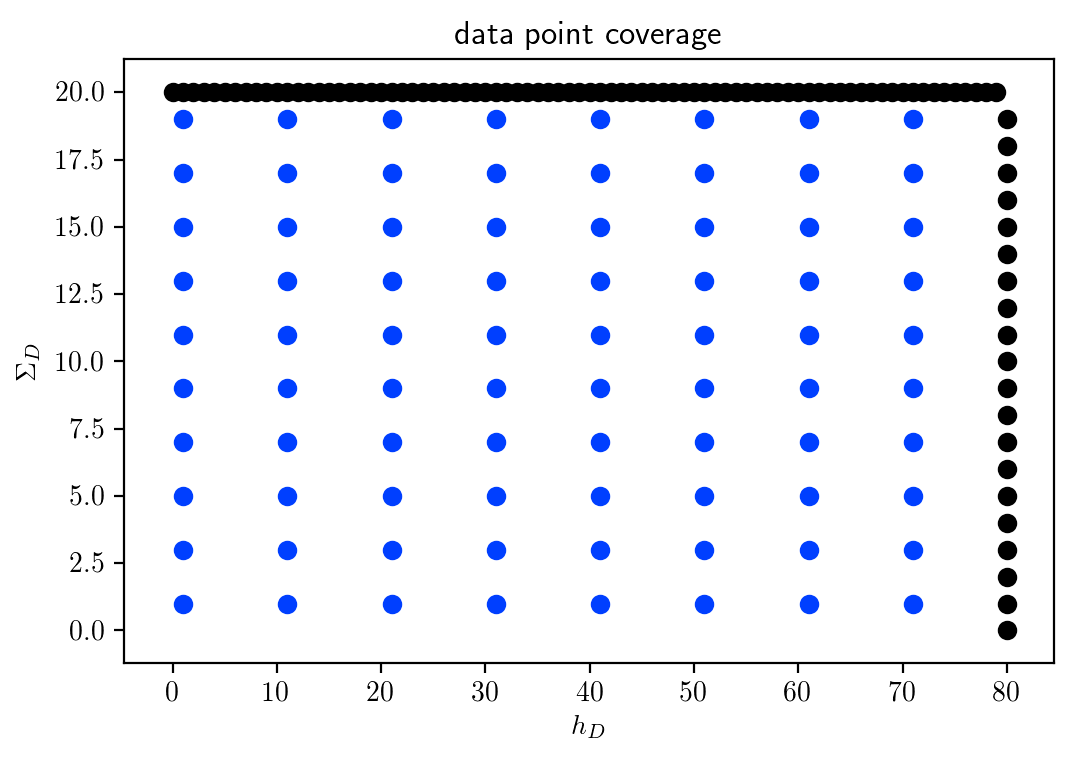

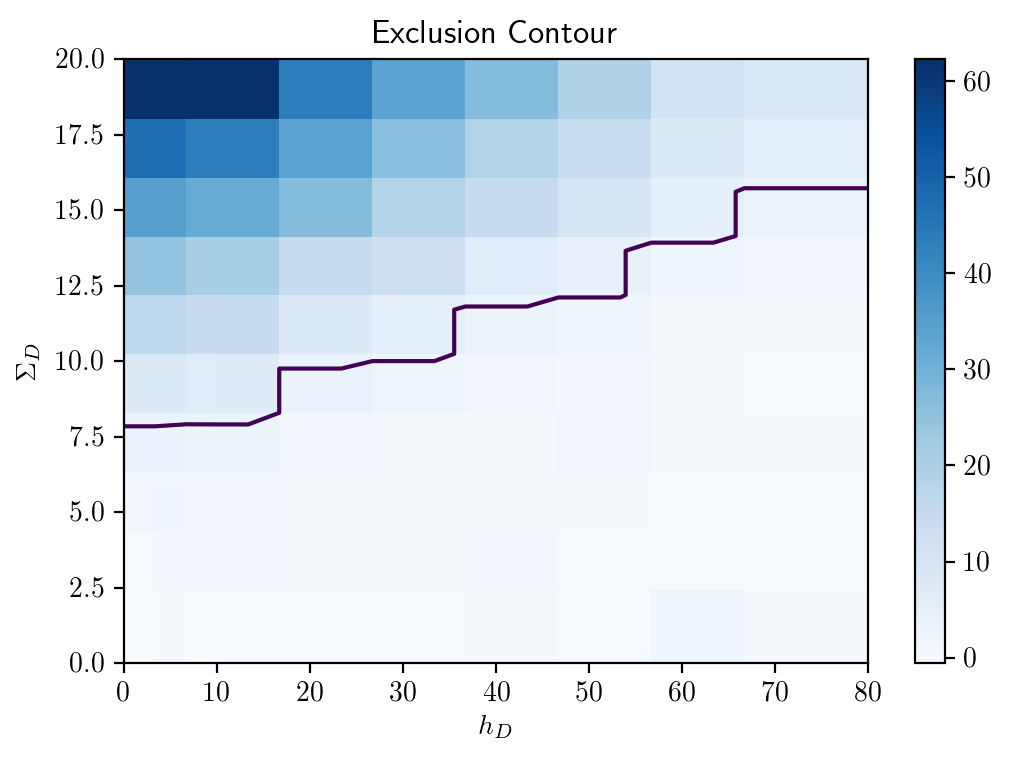

"\nplt.pcolor(spacey, spacex, f_likely, cmap='Blues', vmin=f_likely.min(), vmax=f_likely.max())\nplt.colorbar()\nplt.xlabel('$h_D$'); plt.ylabel('$\\Sigma_D$'); plt.title('llh values')\nplt.show()\n\nplt.pcolor(spacey, spacex, f_opt_likely, cmap='Blues', vmin=f_opt_likely.min(), vmax=f_opt_likely.max())\nplt.colorbar()\nplt.xlabel('$h_D$'); plt.ylabel('$\\Sigma_D$'); plt.title('llh max_sgm_DD values')\nplt.show()"

In [21]:
cl_contour = [3.84]

border_x = 80
border_y = 20

plt.scatter(interpy, interpx)
plt.scatter(np.array([border_x for k in range(border_y)]),np.array([k for k in range(border_y)]),color='black')
plt.scatter(np.array([k for k in range(border_x)]),np.array([border_y for k in range(border_x)]),color='black')
plt.title('data point coverage'); plt.ylabel('$\Sigma_D$'); plt.xlabel('$h_D$');
plt.show()

spacex, spacey = np.mgrid[0:20:42j,0:80:25j]

f_likely = interp.griddata(np.array(interpxy), np.array(interpz), (spacex,spacey), method='nearest')
f_opt_likely = interp.griddata(np.array(interpxy0), np.array(interpz0), (spacex,spacey), method='nearest')


outputx = spacex[:,0]
outputy = spacey[0,:]

plot_z = 2*(f_likely - f_opt_likely)

spacex = np.transpose(spacex)
spacey = np.transpose(spacey)
plot_z = np.transpose(plot_z)
f_likely = np.transpose(f_likely)
f_opt_likely = np.transpose(f_opt_likely)

plt.pcolor(spacey, spacex, plot_z, cmap='Blues', vmin=plot_z.min(), vmax=plot_z.max())
plt.colorbar()
plt.contour(spacey, spacex, plot_z, cl_contour)
plt.xlabel('$h_D$'); plt.ylabel('$\Sigma_D$'); plt.title('Exclusion Contour')
plt.savefig("/Users/john/Documents/"+star_Cat+"_stars.jpg")
plt.show()

#------------------- Plot also the pointwise llh and column-wise llh values---------------------
"""
plt.pcolor(spacey, spacex, f_likely, cmap='Blues', vmin=f_likely.min(), vmax=f_likely.max())
plt.colorbar()
plt.xlabel('$h_D$'); plt.ylabel('$\Sigma_D$'); plt.title('llh values')
plt.show()

plt.pcolor(spacey, spacex, f_opt_likely, cmap='Blues', vmin=f_opt_likely.min(), vmax=f_opt_likely.max())
plt.colorbar()
plt.xlabel('$h_D$'); plt.ylabel('$\Sigma_D$'); plt.title('llh max_sgm_DD values')
plt.show()"""

## Emcee

Emcee is a program for MCMC study of the log-likelihood function. 

In *EnsembleSampler*, we set up *nwalkers*, the number of walkers that will sample the parameter space wth random walk; and *ndim* the dimension of parameter space = number of paramter. Then we run *run_mcmc* to start the sampling. The two arguments, *pos* is the initial position of the walkers, which we set to be a small random ball centered at param_long; *nsteps* is the number of steps the walkers going to take before the sampling ends. The steps should be a value greater than the burn-in time and sufficient for the walkers to sample a sufficiently large parameter space

In [46]:
delta = 1e-2
nwalkers = 70
nsteps = 1000

h_DD_init = 10.; sig_DD_init = 5.

param_long = h_DD_init, sig_DD_init, dens_norm, sunZ, rhoDHalo, sigmaH2, sigmaHI1, sigmaHI2, sigmaWGas, sigmaGiants,\
   sigmaMV2p5, sigma3MV4, sigma4MV5, sigma5MV8, sigmaMV8, sigmaWDwarfs, sigmaBDwarfs, rhoH2, rhoHI1, rhoHI2,\
   rhoWGas, rhoGiants, rhoMV2p5, rho3MV4, rho4MV5, rho5MV8, rhoMV8, rhoWDwarfs, rhoBDwarfs

initial_guess = param_long


ndim = len(initial_guess)
print("Dimension is " + str(ndim) + ".")

pos = [initial_guess + delta*np.random.randn(ndim)*param_long for i in range(nwalkers)]
logic = True, False, False

sampler = mc.EnsembleSampler(nwalkers, ndim, lh.loglikelihood_emcee, \
                             args=(zdata, wdata, sunW, logic, mean_param, err_param, mean_lin_param, width_lin_param, star_Cat, w_file))

%time sampler.run_mcmc(pos, nsteps)
result = sampler.chain[:, 10:, :].reshape((-1, ndim))

result_exp = result
model_return = map(lambda v: (v[0]), zip(*np.percentile(result_exp, [0], axis=0)))
model_error = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(result_exp, [16, 50, 84], axis=0)))

logic = True, False, False
h_DD_ret = model_return[0]
sig_DD_ret = model_return[1]
short_param = model_return[2:]

llh_rett = lh.loglikelihood_trueW(short_param, h_DD_ret, sig_DD_ret, zdata, wdata, sunW, logic, mean_param, err_param, mean_lin_param, width_lin_param, star_Cat, w_file)

print("Best-fit likelihood: " + str(llh_rett) )
print("Best-fit disk parameters: " + str(h_DD_ret) + ", " + str(sig_DD_ret))
print("fitting disk parameter 15, 50, 84 percentile: " + str(model_error[0]) + ", " + str(model_error[1]))

#print("Best fit model parameters: " + str(model_return))
#print("Parameter uncertainties: " + str(model_error))

Dimension is 29.
CPU times: user 2h 13min 27s, sys: 18.2 s, total: 2h 13min 45s
Wall time: 2h 14min
Best-fit likelihood: 295.591890575
Best-fit disk parameters: 0.00622557300548, 0.0245962837759
fitting disk parameter 15, 50, 84 percentile: (8.6623727166979432, 2.2853466922435732, 2.95509373507321), (4.4206751783123543, 1.3585385995531096, 1.7767202042109784)


We examine the burn-in time and acceptance rate of the Emcee sampler chain. The burn-in time reflects the time it takes for the walkers to reach equilibrium and thus find the global minimum. The walker track graphs should reflect time-translation symmetry when burn-in time is reached. How well the walkers have thoroughly sampled the parameter space should be reflected upon the acceptance rate.

Walker tracks:


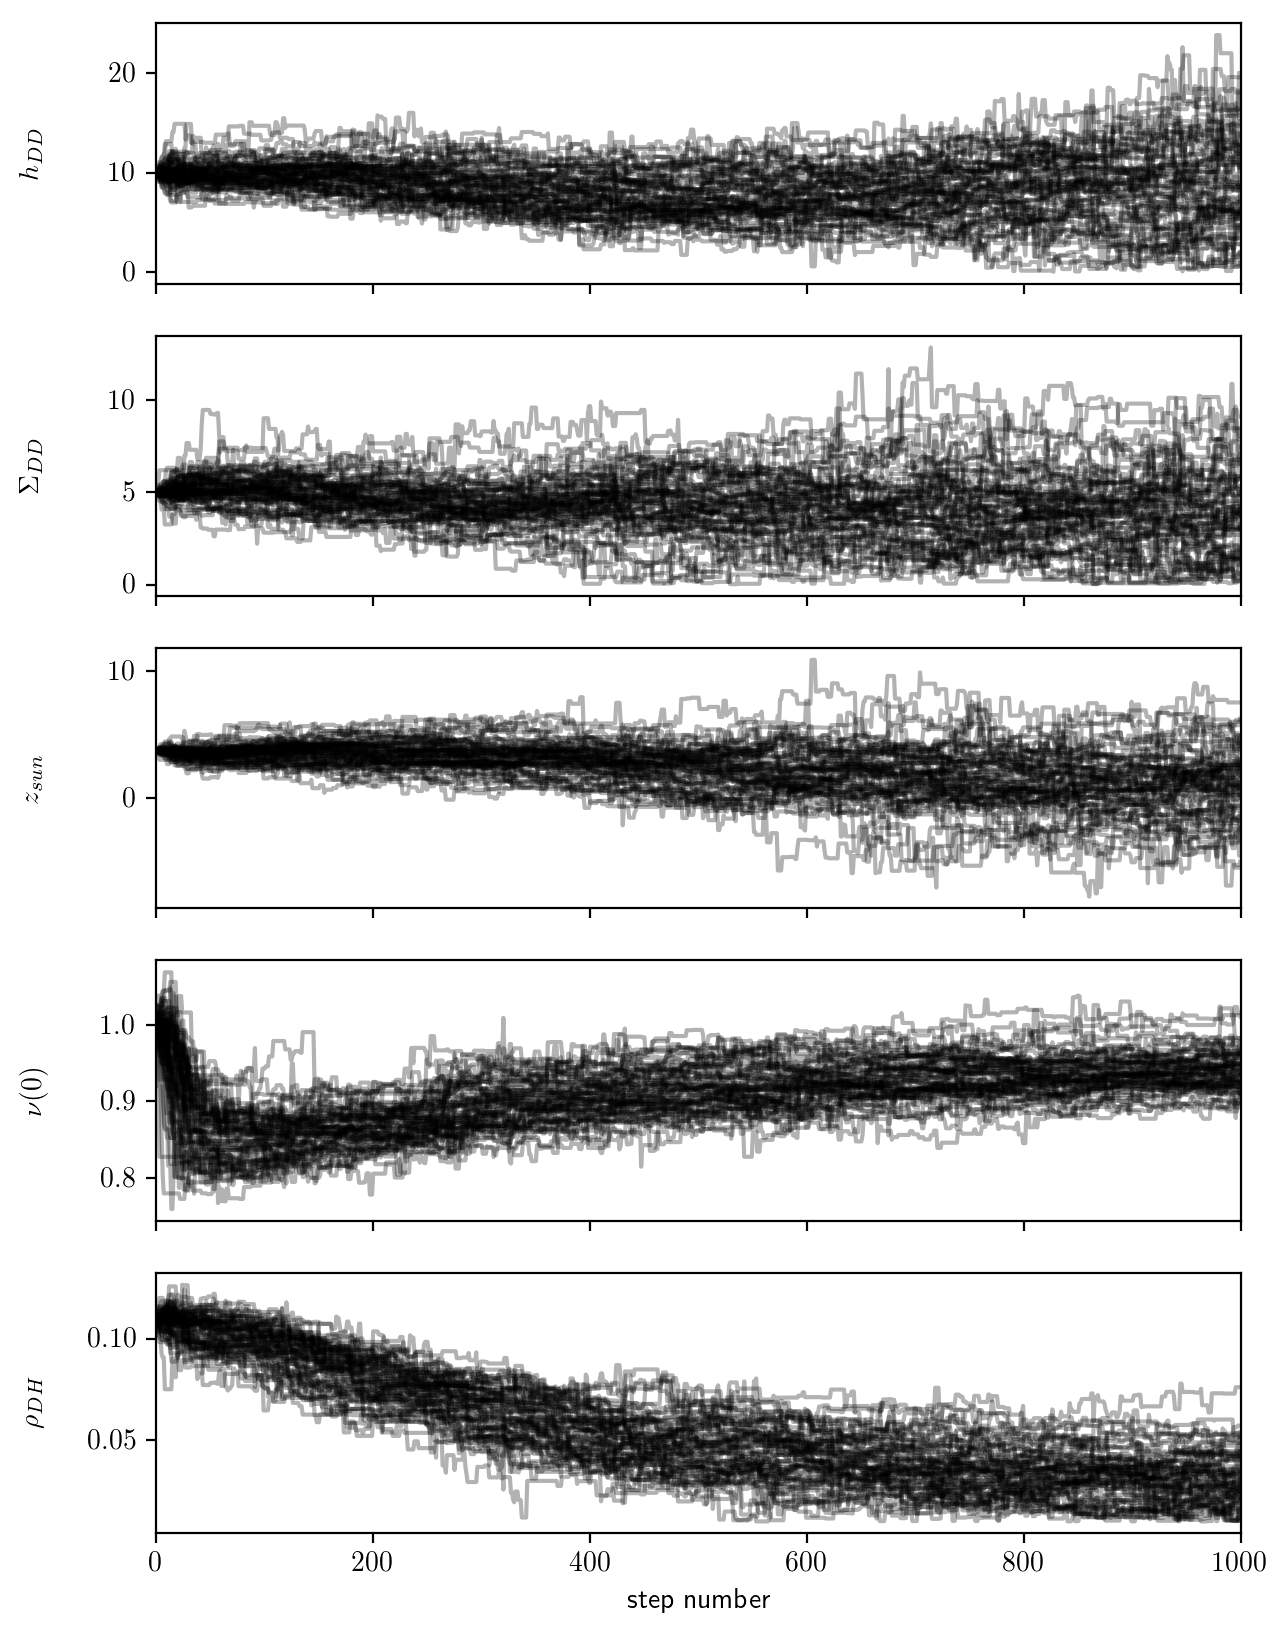

Sample acceptance fractions:


array([ 0.225,  0.233,  0.181,  0.203,  0.208,  0.253,  0.241,  0.227,
        0.241,  0.233,  0.212,  0.225,  0.2  ,  0.205,  0.224,  0.206,
        0.221,  0.21 ,  0.223,  0.216,  0.213,  0.236,  0.233,  0.224,
        0.234,  0.265,  0.219,  0.198,  0.198,  0.218,  0.196,  0.188,
        0.222,  0.216,  0.227,  0.243,  0.206,  0.186,  0.238,  0.213,
        0.215,  0.227,  0.242,  0.251,  0.196,  0.204,  0.226,  0.202,
        0.22 ,  0.225,  0.211,  0.221,  0.237,  0.218,  0.234,  0.201,
        0.233,  0.228,  0.226,  0.228,  0.191,  0.2  ,  0.214,  0.222,
        0.226,  0.221,  0.244,  0.215,  0.214,  0.239])

In [105]:
indx_h_DD = 0
indx_Sgm_DD = 1
indx_dens_norm = 2
indx_sunZ = 3
indx_rhoDHalo = 4
indx_sigmaH2 = 5
indx_rhoH2 = 17

nPlot = 5

print("Walker tracks:")
fig, axes = plt.subplots(nPlot, figsize=(7, 10), sharex=True)
samples = sampler.chain
labels = ["$h_{DD}$","$\Sigma_{DD}$","$z_{sun}$", "$\\nu(0)$", "$\\rho_{DH}$"]
label_ind= [indx_h_DD, indx_Sgm_DD, indx_sunZ, indx_dens_norm, indx_rhoDHalo]  #indices of the parameters in the result_pow array; for complete list see log_likhood function.
for i in xrange(len(label_ind)):
    ax = axes[i]
    chain= [samples[j, 0:nsteps, label_ind[i]] for j in xrange(len(samples))]
    for j in xrange(len(samples)):    
        ax.plot(chain[j], "k", alpha=0.3)
    ax.set_xlim(0, nsteps)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

print("Sample acceptance fractions:")
sampler.acceptance_fraction

Observe the 2D cross-sections of the marginalized parameter contours. Here we cut away samples before the burn-in time.

This is just the example for the posterior distributions. In actual analysis, we require much more steps for a longer burn-in time, better exploration of parameter space and higher walker acceptance fractions. To acquire that level of precision, we will need to run the program on a grid.

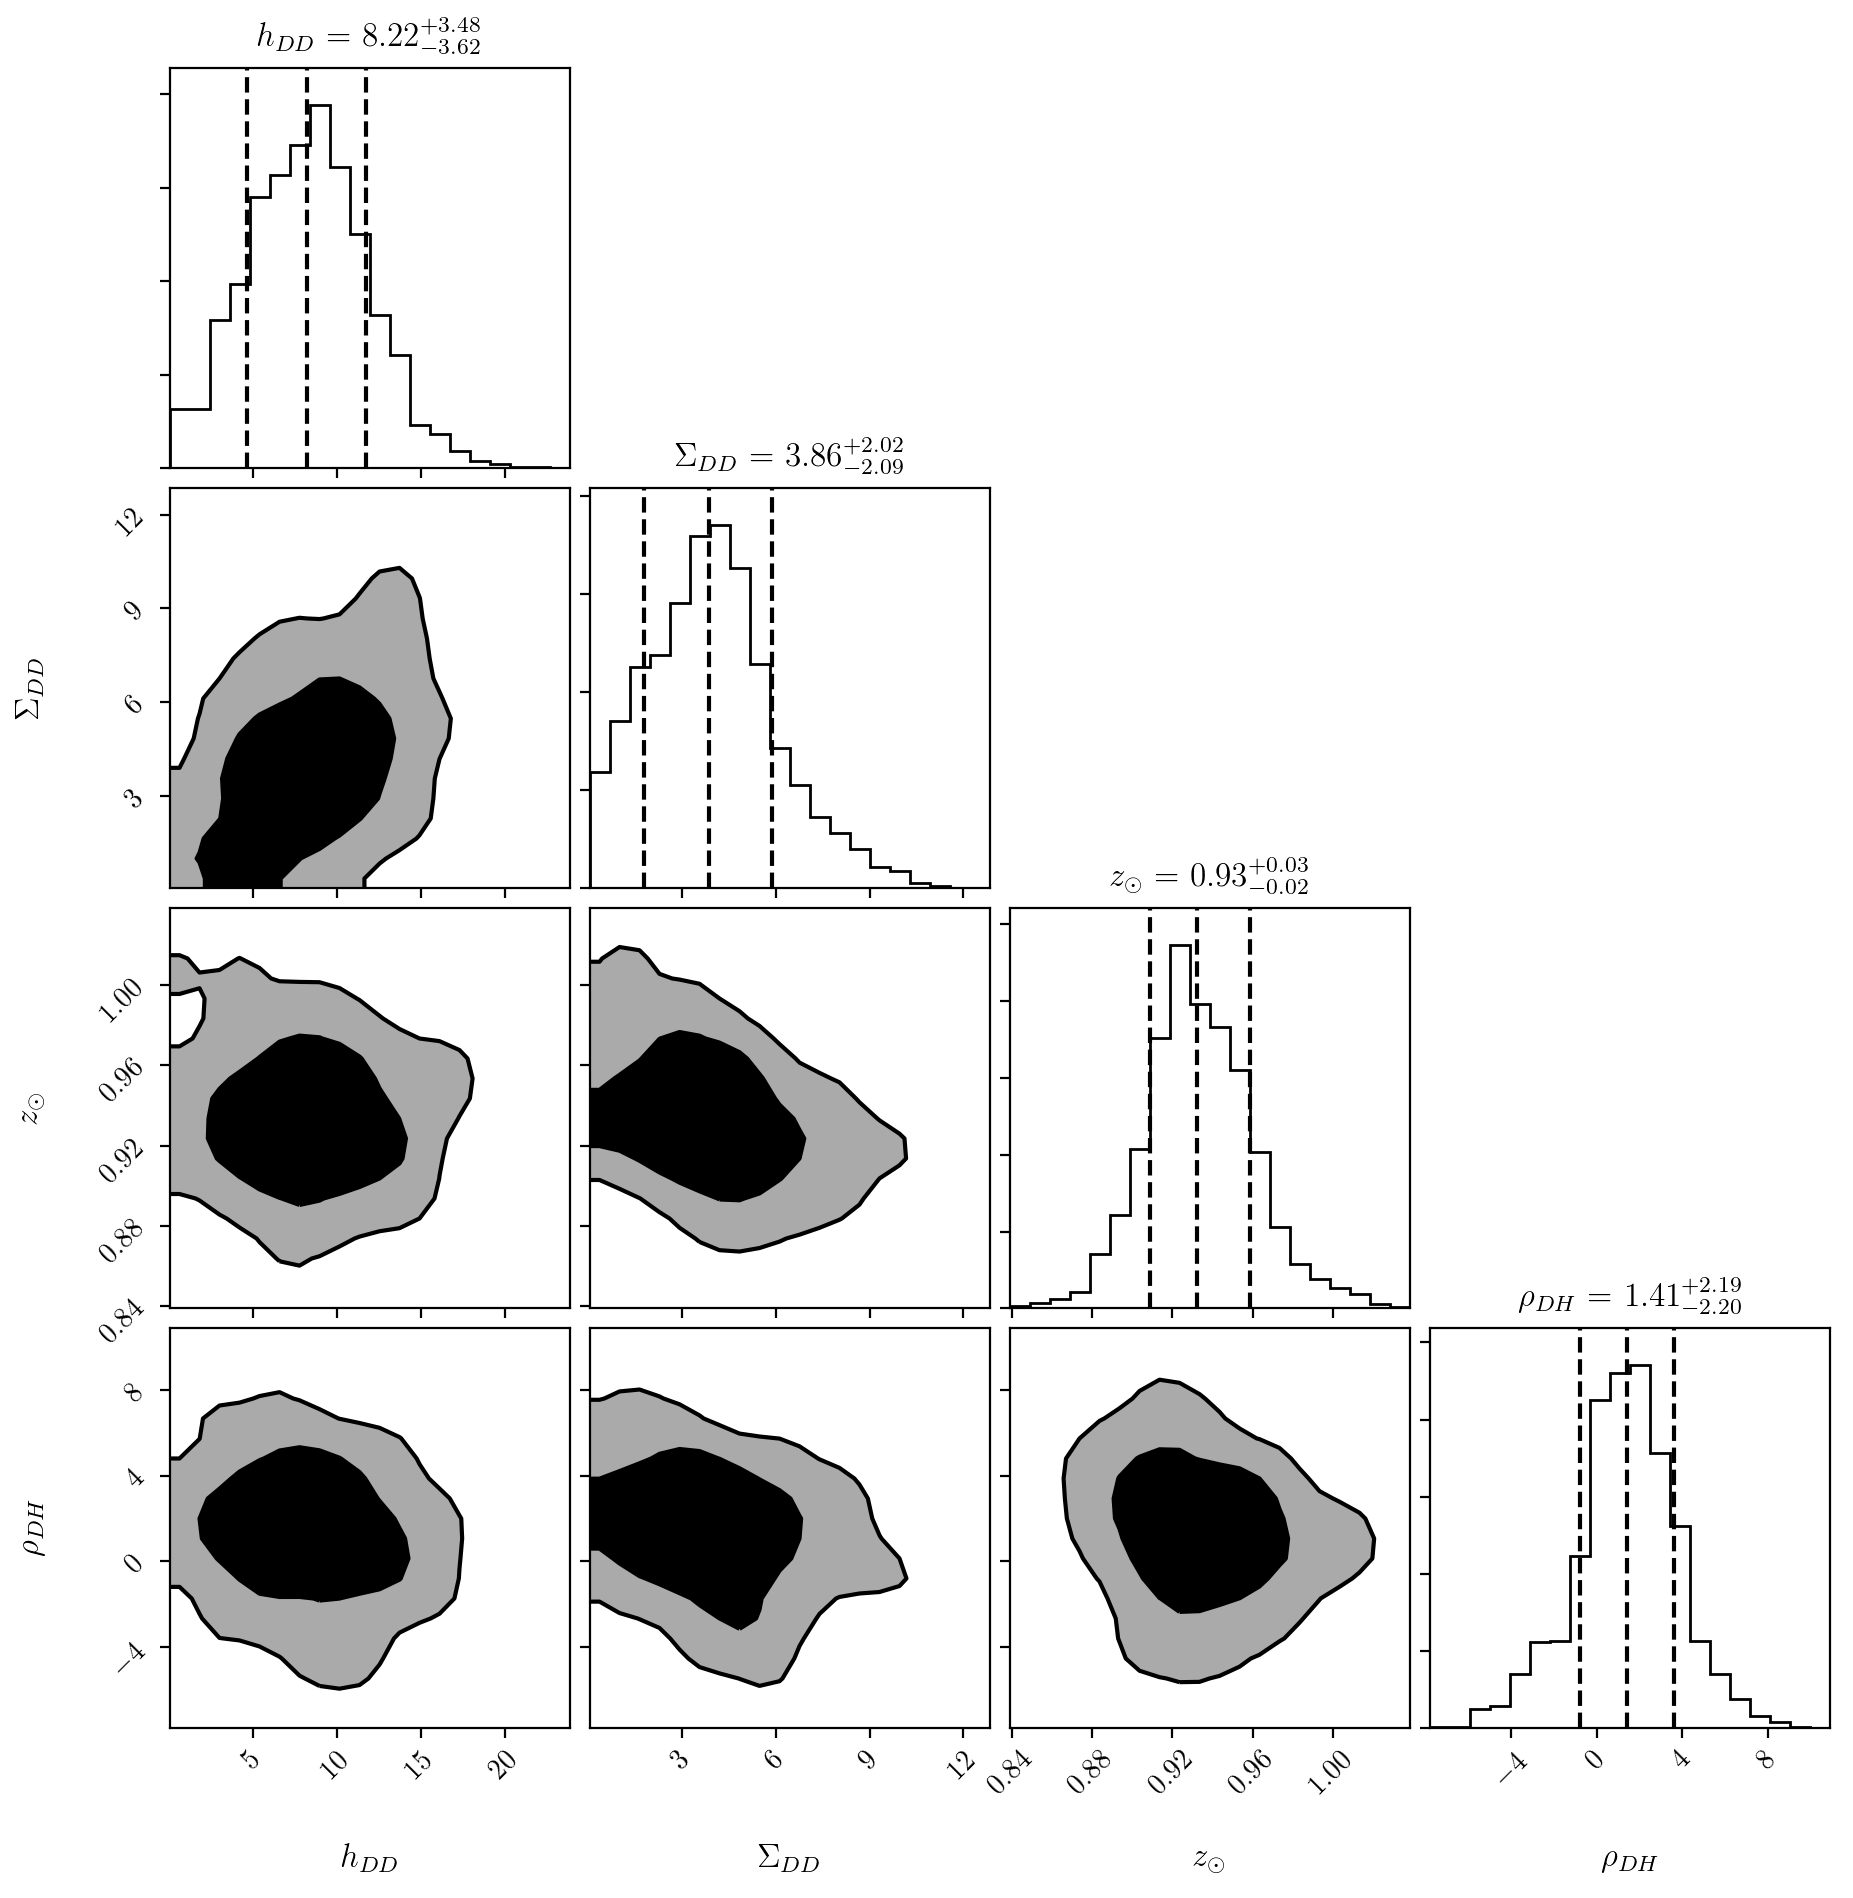

In [107]:
burn_in_steps = 600
nplots = 4
plot_labels = ["$h_{DD}$","$\Sigma_{DD}$", "$z_{\odot}$", "$\\rho_{DH}$"]
save_data = True

sample_slides = (sampler.chain[:,burn_in_steps:,:(nplots-ndim)]).reshape((-1, nplots)) 
#sample_slides = sampler.chain[:,burn_in_steps:,8].reshape(-1, 1) 
    
figure = corner.corner(sample_slides, labels = plot_labels, label_kwargs=dict(fontsize=12), \
                plot_datapoints=False, plot_density=False, fill_contours=True, quantiles=[0.16, 0.5, 0.84], \
                show_titles=True, smooth=True, levels=(0.68, 0.95))


if save_data == True:
   df= [pd.DataFrame(sampler.chain[:,:,i]) for i in xrange(ndim)]
   for i in xrange(ndim):
      df[i].to_pickle("data_%d" %i +"emcee.pkl.compress", compression="gzip")
    
   figure.savefig("emcee_posterior.png", bbox_inches='tight')